This notebook uses a new version of NaMaster (respect to the previous notebooks)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
from scipy import stats
import check_covariance_code.common as co
from check_covariance_code import flatmaps as fm
import healpy as hp
import numpy as np
import pymaster as nmt
import os

In [3]:
prefix =  'run_flat_2b'
run_path = os.path.join('./simulations_outputs/', prefix, prefix)
data_folder = './data/'
# sims_suffix = '_clsims_0001-0100.npz' Not used in this case
nside=512 # I think it can be read from somewhere

# Common

## Load theoretical data and sampled data

In [4]:
f = np.load(os.path.join(data_folder,"cls_lss_2bins.npz"))
lTh = f['ls']
clTh_all = (f['cls'] + f['nls'])[np.triu_indices(f['cls'].shape[0])]
clTh_all_won = (f['cls'])[np.triu_indices(f['cls'].shape[0])]
clTh =  (f['cls'] + f['nls'])[np.ix_([0, 1, 2], [3, 4, 5])].reshape((9, -1))

clTh_TT, clTh_TE, clTh_TB, clTh_ET, clTh_EE, clTh_EB, clTh_BT, clTh_BE, clTh_BB = clTh

In [5]:
clTh_all.shape

(21, 30000)

Check script: compare th cl's computed with original ones.

In [85]:
f = np.load(run_path + "_cl_th.npz")
lTh_s = f['ls']
clTh_s =  f['cls']

In [86]:
clTh_s.shape

(21, 73)

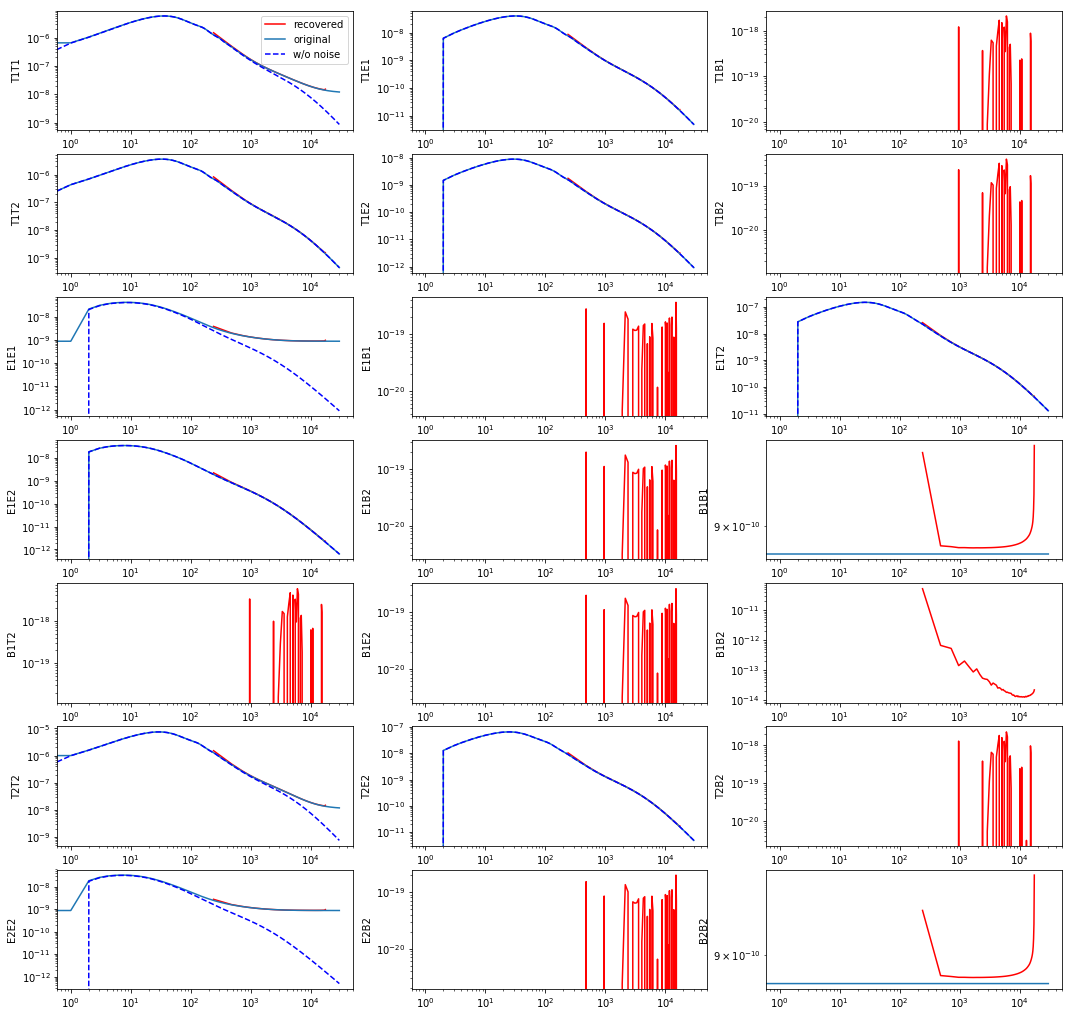

In [87]:
f, axs = plt.subplots(7, 3, figsize=(18, 18))

labels = ["T1T1", "T1E1", "T1B1", "T1T2", "T1E2", "T1B2",
          "E1E1", "E1B1", "E1T2", "E1E2", "E1B2", 
          "B1B1", "B1T2", "B1E2", "B1B2", 
          "T2T2", "T2E2", "T2B2", 
          "E2E2", "E2B2",
          "B2B2"]

for cls, clt, clt_won, ax, lab in zip(clTh_s, clTh_all, clTh_all_won, axs.reshape(-1), labels):
    ax.plot(lTh_s, cls,'r-', label='recovered')
    ax.plot(lTh, clt, label='original')
    ax.plot(lTh,clt_won, 'b--', label='w/o noise')
    ax.set_ylabel(lab)
    ax.loglog()
axs[0,0].legend(loc=0)
plt.show()
plt.close()

In [9]:
fmi,mask_hsc=fm.read_flat_map("data/mask_lss_flat.fits")
fsky=np.sum(mask_hsc * np.radians(fmi.dx) * np.radians(fmi.dy)) / (4 * np.pi)

# Used later for naive cov and to generate fields.
ell_min=max(2*np.pi/fmi.lx_rad,2*np.pi/fmi.ly_rad)
ell_max=min(fmi.nx*np.pi/fmi.lx_rad,fmi.ny*np.pi/fmi.ly_rad)
d_ell=2*ell_min
n_ell=int((ell_max-ell_min)/d_ell)-1
l_bpw=np.zeros([2,n_ell])
l_bpw[0,:]=ell_min+np.arange(n_ell)*d_ell
l_bpw[1,:]=l_bpw[0,:]+d_ell
b=nmt.NmtBinFlat(l_bpw[0,:],l_bpw[1,:])

if not os.path.isfile(run_path + '_ells.txt'):
    np.savetxt(run_path + '_ells.txt', b.get_effective_ells())

In [10]:
def get_fields(fsk,mask,w_cont=False) :
    """
    Generate a simulated field.
    It returns two NmtField objects for a spin-0 and a spin-2 field.

    :param fsk: a fm.FlatMapInfo object.
    :param mask: a sky mask.
    :param w_cont: deproject any contaminants? (not implemented yet)
    """
    st,sq,su=nmt.synfast_flat(int(fsk.nx),int(fsk.ny),fsk.lx_rad,fsk.ly_rad,
                              [clTh_TT, clTh_TE, clTh_TB, clTh_EE, clTh_EB, clTh_BB], [0,2])
    if w_cont :
        if np.any(templates_all):
            tst, tsq, tsu = templates_all.sum(axis=0)
            st+=tst; sq+=tsq; su+=tsu;
        if o.no_deproject :
            ff0=nmt.NmtFieldFlat(fsk.lx_rad,fsk.ly_rad,mask.reshape([fsk.ny,fsk.nx]),
                                 [st])
            ff2=nmt.NmtFieldFlat(fsk.lx_rad,fsk.ly_rad,mask.reshape([fsk.ny,fsk.nx]),
                                 [sq, su])
        else :
            ff0=nmt.NmtFieldFlat(fsk.lx_rad,fsk.ly_rad,mask.reshape([fsk.ny,fsk.nx]),
                                 [st],
                                 templates=templates_all[:,0,None,:])
            ff2=nmt.NmtFieldFlat(fsk.lx_rad,fsk.ly_rad,mask.reshape([fsk.ny,fsk.nx]),
                                 [sq,su],
                                 templates=templates_all[:,1:, :])
    else :
        ff0=nmt.NmtFieldFlat(fsk.lx_rad,fsk.ly_rad,mask.reshape([fsk.ny,fsk.nx]),
                             [st])
        ff2=nmt.NmtFieldFlat(fsk.lx_rad,fsk.ly_rad,mask.reshape([fsk.ny,fsk.nx]),
                             [sq,su])
    return ff0,ff2

np.random.seed(1000)
f0,f2=get_fields(fmi,mask_hsc, 'contaminants' in prefix)

### Simulations correlations

In [77]:
from glob import glob
clfiles = glob(run_path + '_cl_0*.npz')[:2000]

cl_ar2000 = np.empty((len(clTh_s), len(clfiles), b.get_n_bands()))

for i, clf in enumerate(clfiles):
    cl = np.load(clf)['cls']
    cl_ar[:, i] = cl  # [[3, 4, 5, 6, 9, 7, 8, 10, 11]]
    
#clTT, clTE, clTB, clET, clEE, clEB, clBT, clBE, clBB = cl_ar
nlbins = b.get_n_bands()
lbins = b.get_effective_ells()
cl_ar_mean2000 = np.mean(cl_ar2000, axis=1)

In [78]:
cl_ar2000.shape

(21, 999, 73)

In [83]:
from glob import glob
clfiles = glob(run_path + '_cl_[0-9]*.npz')

cl_ar = np.empty((len(clTh_s), len(clfiles), b.get_n_bands()))

for i, clf in enumerate(clfiles):
    cl = np.load(clf)['cls']
    cl_ar[:, i] = cl  # [[3, 4, 5, 6, 9, 7, 8, 10, 11]]
    
#clTT, clTE, clTB, clET, clEE, clEB, clBT, clBE, clBB = cl_ar
nlbins = b.get_n_bands()
lbins = b.get_effective_ells()
cl_ar_mean = np.mean(cl_ar, axis=1)

In [ ]:
cl_ar.shape

In [ ]:
cl_ar[:,0,0]

In [ ]:
cl_ar[:,9,0]

In [ ]:
A = np.sum((clTh_s - cl_ar_mean2000)**2, axis=-1)

In [ ]:
B = np.sum((clTh_s - cl_ar_mean)**2, axis=-1)

In [81]:
print(list(zip(A,B)))

[(2778521630.5827913, 9.297796506111592e-15), (236.60437678251316, 1.711100099365287e-21), (40063651.58556245, 5.096274698451198e-21), (2149577378.385905, 5.714051693073487e-17), (964.059838792449, 1.1633920838007562e-21), (2778258240.2806163, 4.796919173959478e-22), (718.8645316537549, 5.771174244726717e-17), (174540873.63299966, 8.992486657488786e-24), (1432782458.7956018, 7.5612331253513e-20), (18102033.5910383, 6.928078027338962e-22), (2663028755.5080233, 2.2558634602977672e-23), (15161629.720019057, 5.777829136651119e-17), (381094144.9398537, 2.2201938699516874e-20), (904833285.7647121, 1.1044674483348185e-23), (452.74597271442525, 1.5071192720160494e-23), (2778933893.2326565, 9.28746156294796e-15), (907.2139245636309, 1.627743613703122e-20), (1190647489.7374299, 7.95799160594871e-22), (256720362.31983134, 5.774432593367351e-17), (2640921263.931736, 5.964236855843603e-24), (nan, 5.777570882964492e-17)]


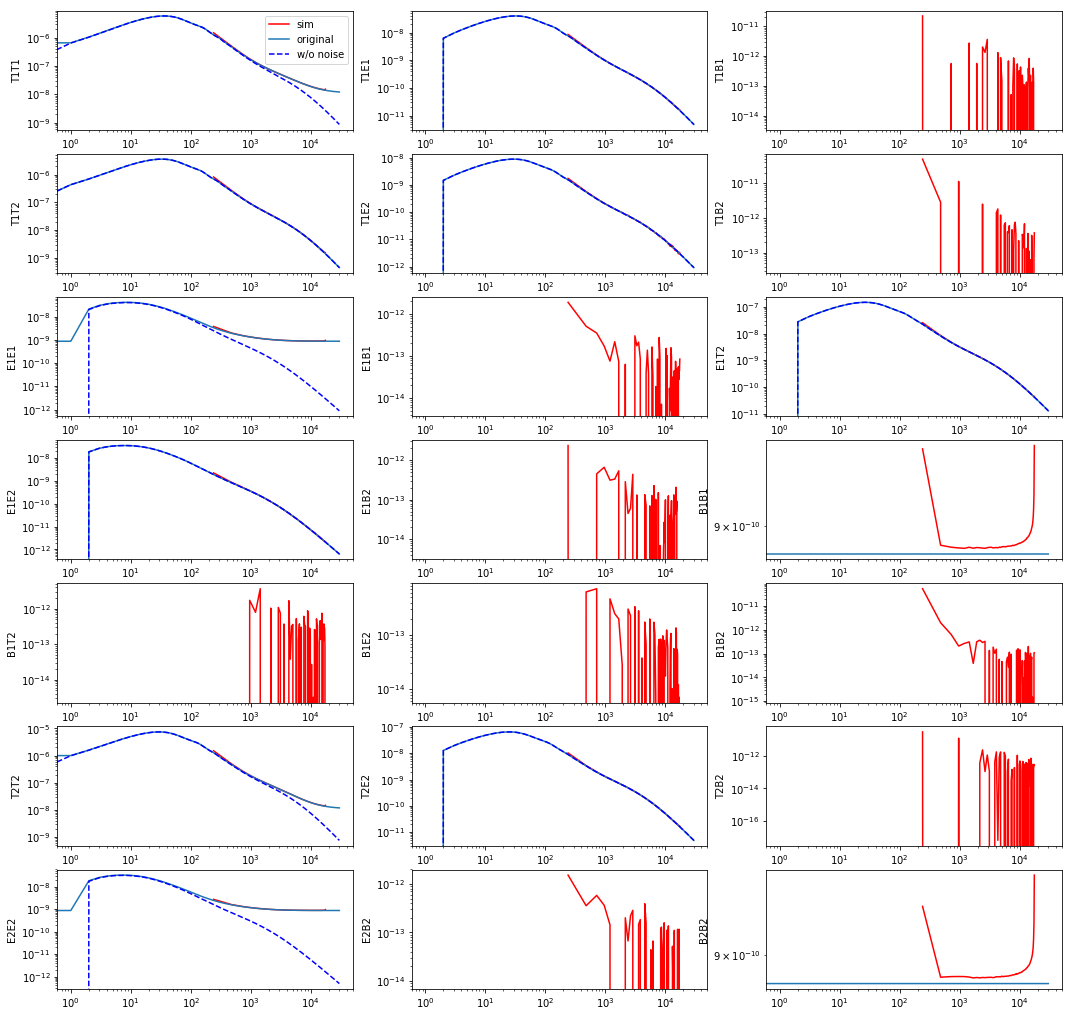

In [84]:
f, axs = plt.subplots(7, 3, figsize=(18, 18))

labels = ["T1T1", "T1E1", "T1B1", "T1T2", "T1E2", "T1B2",
          "E1E1", "E1B1", "E1T2", "E1E2", "E1B2", 
          "B1B1", "B1T2", "B1E2", "B1B2", 
          "T2T2", "T2E2", "T2B2", 
          "E2E2", "E2B2",
          "B2B2"]

for cls, clt, clt_won, ax, lab in zip(cl_ar_mean, clTh_all, clTh_all_won, axs.reshape(-1), labels):
    #ax.plot(lTh_s, cls2,'g-.', label='sim2')
    ax.plot(lTh_s, cls,'r-', label='sim')
    ax.plot(lTh, clt, label='original')
    ax.plot(lTh,clt_won, 'b--', label='w/o noise')
    ax.set_ylabel(lab)
    ax.loglog()
axs[0,0].legend(loc=0)
plt.show()
plt.close()

Healpix has bins of same area but its integrals are not completely exact. Sometimes the best we can do is up to (2 x nbins)

In [42]:
lmax = len(lbins) # (clsims['l'] < 2*512).sum()

In [43]:
CovSims_path = run_path + '_cov'+sims_suffix
if os.path.isfile(CovSims_path):
    C = np.load(CovSims_path)['arr_0']
else:
    C = np.cov(np.concatenate([clTT.T, clTE.T, clTB.T, clEE.T, clEB.T, clBB.T]))
    np.savez_compressed(CovSims_path, C)
C = C.reshape((6, nlbins, 6, nlbins))

In [44]:
CovSims_TT = C[0, :, 0, :]
CovSims_TE = C[1, :, 1, :]
CovSims_TB = C[2, :, 2, :]
CovSims_EE = C[3, :, 3, :]
CovSims_EB = C[4, :, 4, :]
CovSims_BB = C[5, :, 5, :]

CovSims_TTTE = C[0, :, 1, :]
CovSims_TTTB = C[0, :, 2, :]
CovSims_TTEE = C[0, :, 3, :]
CovSims_TTEB = C[0, :, 4, :]
CovSims_TTBB = C[0, :, 4, :]

CovSims_TETB = C[1, :, 2, :]
CovSims_TEEE = C[1, :, 3, :]
CovSims_TEEB = C[1, :, 4, :]
CovSims_TEBB = C[1, :, 5, :]

CovSims_TBEE = C[2, :, 3, :]
CovSims_TBEB = C[2, :, 4, :]
CovSims_TBBB = C[2, :, 5, :]

CovSims_EEEB = C[3, :, 4, :]
CovSims_EEBB = C[3, :, 5, :]

CovSims_EBBB = C[4, :, 5, :]

if os.path.isfile(run_path + '_covTTTEEE'+sims_suffix):
    CovSims_TTTEEE = np.load(run_path + '_covTTTEEE'+sims_suffix)['arr_0']
else:
    CovSims_TTTEEE = np.block([[CovSims_TT, CovSims_TTTE, CovSims_TTEE], 
                               [CovSims_TTTE.T, CovSims_TE, CovSims_TEEE], 
                               [CovSims_TTEE.T, CovSims_TEEE.T, CovSims_EE]])
    np.savez_compressed(run_path + '_covTTTEEE'+sims_suffix, CovSims_TTTEEE)

### Analytic Covariances

In [49]:
suffix_2b = '_12'

In [50]:
w00 = nmt.NmtWorkspaceFlat()
w00.read_from(run_path + "_w00{}.dat".format(suffix_2b))
w02 = nmt.NmtWorkspaceFlat()
w02.read_from(run_path + "_w02{}.dat".format(suffix_2b))
w22 = nmt.NmtWorkspaceFlat()
w22.read_from(run_path + "_w22{}.dat".format(suffix_2b))

We don't need to create a different covariance workspace for each spin combination because it only depends on the masks of the field

In [51]:
cw = nmt.NmtCovarianceWorkspaceFlat()

if os.path.isfile(run_path + '_cw{}.dat'.format(suffix_2b)):
    cw.read_from(run_path + '_cw{}.dat'.format(suffix_2b))
else: 
    cw.compute_coupling_coefficients(f0, f0, b)
    cw.write_to(run_path + '_cw{}.dat'.format(suffix_2b))

#### Approx Efstathiou

In [52]:
cltt = clTh_TT
clte = clTh_TE
clee = clTh_EE
clbb = clTh_BB

if os.path.isfile(run_path+'_c0000{}.npz'.format(suffix_2b)):
    c0000 = np.load(run_path+'_c0000{}.npz'.format(suffix_2b))['arr_0']
else:
    c0000=nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[cltt],[cltt],[cltt],[cltt],w00); print(c0000.shape)
    np.savez_compressed(run_path+'_c0000{}.npz'.format(suffix_2b), c0000)
    
if os.path.isfile(run_path+'_c0002{}.npz'.format(suffix_2b)):
    c0002 = np.load(run_path+'_c0002{}.npz'.format(suffix_2b))['arr_0']
else:
    c0002=nmt.gaussian_covariance_flat(cw,0,0,0,2,lTh,[cltt],[clte,0*clte],[cltt],[clte,0*clte],w00,w02).reshape((nlbins, 1, nlbins, 2)); print(c0002.shape)
    np.savez_compressed(run_path+'_c0002{}.npz'.format(suffix_2b), c0002)
    
if os.path.isfile(run_path+'_c0022{}.npz'.format(suffix_2b)):
    c0022 = np.load(run_path+'_c0022{}.npz'.format(suffix_2b))['arr_0']
else:
    c0022=nmt.gaussian_covariance_flat(cw,0,0,2,2,lTh,[clte,0*clte],[clte,0*clte],[clte,0*clte],[clte,0*clte],w00,w22).reshape((nlbins, 1, nlbins, 4)); print(c0022.shape)
    np.savez_compressed(run_path+'_c0022{}.npz'.format(suffix_2b), c0022)
    
if os.path.isfile(run_path+'_c0202{}.npz'.format(suffix_2b)):
    c0202 = np.load(run_path+'_c0202{}.npz'.format(suffix_2b))['arr_0']
else:
    c0202=nmt.gaussian_covariance_flat(cw,0,2,0,2,lTh,[cltt],[clte,0*clte],[clte,0*clte],[clee,0*clee,0*clbb,clbb],w02,w02).reshape((nlbins, 2, nlbins, 2)); print(c0202.shape)
    np.savez_compressed(run_path+'_c0202{}.npz'.format(suffix_2b), c0202)
    
if os.path.isfile(run_path+'_c0222{}.npz'.format(suffix_2b)):
    c0222 = np.load(run_path+'_c0222{}.npz'.format(suffix_2b))['arr_0']
else:
    c0222=nmt.gaussian_covariance_flat(cw,0,2,2,2,lTh,[clte,0*clte],[clte,0*clte],[clee,0*clee,0*clbb,clbb],[clee,0*clee,0*clbb,clbb],w02,w22).reshape((nlbins, 2, nlbins, 4)); print(c0222.shape)
    np.savez_compressed(run_path+'_c0222{}.npz'.format(suffix_2b), c0222)
    
if os.path.isfile(run_path+'_c2222{}.npz'.format(suffix_2b)):
    c2222 = np.load(run_path+'_c2222{}.npz'.format(suffix_2b))['arr_0']
else:
    c2222=nmt.gaussian_covariance_flat(cw,2,2,2,2,lTh,[clee,0*clee,0*clbb,clbb],[clee,0*clee,0*clbb,clbb],[clee,0*clee,0*clbb,clbb],[clee,0*clee,0*clbb,clbb],w22,w22).reshape((nlbins, 4, nlbins, 4)); print(c2222.shape)
    np.savez_compressed(run_path+'_c2222{}.npz'.format(suffix_2b), c2222)
    
    
# c0020=nmt.gaussian_covariance_flat(cw,0,0,2,0,[clte,0*clte],[cltt],[clte,0*clte],[cltt],w00,w02); print(c0020.shape)
#c0200=nmt.gaussisloan_covariance_flat(cw,0,2,0,0,[cltt],[cltt],[clte,0*clte],[clte,0*clte],w02,w00); print(c0200.shape)
#c0220=nmt.gaussian_covariance_flat(cw,0,2,2,0,[clte,0*clte],[cltt],[clee,0*clee,0*clbb,clbb],[clte,0*clte],w02,w02); print(c0220.shape)
#c2000=nmt.gaussian_covariance_flat(cw,2,0,0,0,[clte,0*clte],[clte,0*clte],[cltt],[cltt],w02,w00); print(c2000.shape)
#c2002=nmt.gaussian_covariance_flat(cw,2,0,0,2,[clte,0*clte],[clee,0*clee,0*clbb,clbb],[cltt],[clte,0*clte],w02,w02); print(c2002.shape)
#c2020=nmt.gaussian_covariance_flat(cw,2,0,2,0,[clee,0*clee,0*clbb,clbb],[clte,0*clte],[clte,0*clte],[cltt],w02,w02); print(c2020.shape)
#c2022=nmt.gaussian_covariance_flat(cw,2,0,2,2,[clee,0*clee,0*clbb,clbb],[clee,0*clee,0*clbb,clbb],[clte,0*clte],[clte,0*clte],w02,w22); print(c2022.shape)
#c2200=nmt.gaussian_covariance_flat(cw,2,2,0,0,[clte,0*clte],[clte,0*clte],[clte,0*clte],[clte,0*clte],w22,w00); print(c2200.shape)
#c2202=nmt.gaussian_covariance_flat(cw,2,2,0,2,[clte,0*clte],[clee,0*clee,0*clbb,clbb],[clte,0*clte],[clee,0*clee,0*clbb,clbb],w22,w02); print(c2202.shape)
#c2220=nmt.gaussian_covariance_flat(cw,2,2,2,0,[clee,0*clee,0*clbb,clbb],[clte,0*clte],[clee,0*clee,0*clbb,clbb],[clte,0*clte],w22,w02); print(c2220.shape)

CovTh_TT = c0000
CovTh_TTTE, CovTh_TTTB = c0002[:, 0, :, [0, 1]]
CovTh_TTEE, CovTh_TTEB, CovTh_TTBE, CovTh_TTBB = c0022[:, 0, :, [0, 1, 2, 3]]
CovTh_TETE, CovTh_TETB = c0202[:, 0, :, [0, 1] ]
CovTh_TBTE, CovTh_TBTB = c0202[:, 1, :, [0, 1] ]
CovTh_TEEE, CovTh_TEEB, CovTh_TEBE, CovTh_TEBB =  c0222[:, 0, :, [0, 1, 2, 3] ]
CovTh_TBEE, CovTh_TBEB, CovTh_TBBE, CovTh_TBBB = c0222[:, 1, :, [0, 1, 2, 3] ]
CovTh_EEEE, CovTh_EEEB, CovTh_EEBE, CovTh_EEBB = c2222[:, 0, :, [0, 1, 2, 3] ]
CovTh_EBEE, CovTh_EBEB, CovTh_EBBE, CovTh_EBBB = c2222[:, 1, :, [0, 1, 2, 3] ]
CovTh_BEEE, CovTh_BEEB, CovTh_BEBE, CovTh_BEBB = c2222[:, 2, :, [0, 1, 2, 3] ]
CovTh_BBEE, CovTh_BBEB, CovTh_BBBE, CovTh_BBBB = c2222[:, 3, :, [0, 1, 2, 3] ]

CovTh_TE = CovTh_TETE
CovTh_TB = CovTh_TBTB
CovTh_EE = CovTh_EEEE
CovTh_EB = CovTh_EBEB
CovTh_BB = CovTh_BBBB

if os.path.isfile(run_path + '_covThTTTEEE.npz'):
    CovTh_TTTEEE = np.load(run_path + '_covThTTTEEE.npz')['arr_0']
else:
    CovTh_TTTEEE = np.block([[CovTh_TT, CovTh_TTTE, CovTh_TTEE], 
                               [CovTh_TTTE.T, CovTh_TE, CovTh_TEEE], 
                               [CovTh_TTEE.T, CovTh_TEEE.T, CovTh_EE]])
    np.savez_compressed(run_path + '_covThTTTEEE.npz', CovTh_TTTEEE)

(73, 73)
(73, 1, 73, 2)
(73, 1, 73, 4)
(73, 2, 73, 2)
(73, 2, 73, 4)
(73, 4, 73, 4)


In [53]:
len(lTh)

30000

#### Spin 2 ~ Spin 0

In [54]:
cltt = clTh_TT
clte = clTh_TE
cltb = clbe = 0 * cltt
clee = clTh_EE
cleb = clbe = 0 * clee
clbb = clTh_BB

CovTh0_TT = CovTh_TT
CovTh0_TE = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[cltt],[clte],[clte],[clee],w00)
CovTh0_TB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[cltt],[cltb],[cltb],[clbb],w00)
CovTh0_EE = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[clee],[clee],[clee],[clee],w00)
CovTh0_EB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[clee],[cleb],[cleb],[clbb],w00)
CovTh0_BB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[clbb],[clbb],[clbb],[clbb],w00)

CovTh0_TTTE = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[cltt],[clte],[cltt],[clte],w00)
CovTh0_TTTB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[cltt],[cltb],[cltt],[cltb],w00)
CovTh0_TTEE = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[clte],[clte],[clte],[clte],w00)
CovTh0_TTEB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[clte],[cltb],[clte],[cltb],w00)
CovTh0_TTBB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[cltb],[cltb],[cltb],[cltb],w00)

CovTh0_TETB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[cltt],[cltb],[clte],[cleb],w00)
CovTh0_TEEE = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[clte],[clte],[clee],[clee],w00)
CovTh0_TEEB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[clte],[cltb],[clee],[cleb],w00)
CovTh0_TEBB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[cltb],[cltb],[cleb],[cleb],w00)

CovTh0_TBEE = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[clte],[clte],[clbe],[clbe],w00)
CovTh0_TBEB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[clte],[cltb],[clbe],[clbb],w00)
CovTh0_TBBB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[cltb],[cltb],[clbb],[clbb],w00)

CovTh0_EEEB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[clee],[cleb],[clee],[cleb],w00)
CovTh0_EEBB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[cleb],[cleb],[cleb],[cleb],w00)

CovTh0_EBBB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[cleb],[clbb],[cleb],[clbb],w00)

#### Naive approx

In [55]:
ell_min=max(2*np.pi/fmi.lx_rad,2*np.pi/fmi.ly_rad)
ell_max=min(fmi.nx*np.pi/fmi.lx_rad,fmi.ny*np.pi/fmi.ly_rad)
d_ell=2*ell_min
n_ell=int((ell_max-ell_min)/d_ell)-1
l_bpw=np.zeros([2,n_ell])
l_bpw[0,:]=ell_min+np.arange(n_ell)*d_ell
l_bpw[1,:]=l_bpw[0,:]+d_ell
CovThN_TT = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clTh_TT, clTh_TT, clTh_TT, clTh_TT)
CovThN_TE = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clTh_TT, clTh_TE, clTh_TE, clTh_EE)
CovThN_TB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clTh_TT, clTh_TB, clTh_TB, clTh_BB)
CovThN_EE = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clTh_EE, clTh_EE, clTh_EE, clTh_EE)
CovThN_EB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clTh_EE, clTh_EB, clTh_EB, clTh_BB)
CovThN_BB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clTh_BB, clTh_BB, clTh_BB, clTh_BB)

CovThN_TTTE = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, cltt, clte, cltt, clte)
CovThN_TTTB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, cltt, cltb, cltt, cltb)
CovThN_TTEE = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clte, clte, clte, clte)
CovThN_TTEB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clte, cltb, clte, cltb)
CovThN_TTBB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, cltb, cltb, cltb, cltb)

CovThN_TETB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, cltt, cltb, clte, cleb)
CovThN_TEEE = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clte, clte, clee, clee)
CovThN_TEEB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clte, cltb, clee, cleb)
CovThN_TEBB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, cltb, cltb, cleb, cleb)

CovThN_TBEE = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clte, clte, clbe, clbe)
CovThN_TBEB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clte, cltb, clbe, clbb)
CovThN_TBBB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, cltb, cltb, clbb, clbb)

CovThN_EEEB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clee, cleb, clee, cleb)
CovThN_EEBB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, cleb, cleb, cleb, cleb)

CovThN_EBBB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, cleb, clbb, cleb, clbb)

# Efstathiou approximation

## TTTT

Checks for TTTT
Diagonal covariance matrix


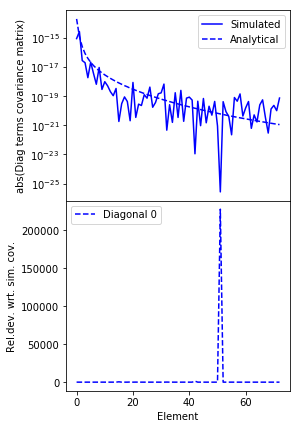

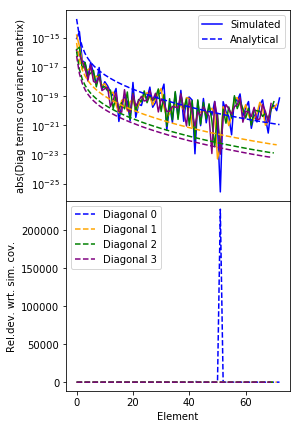

Chi2 distribution check


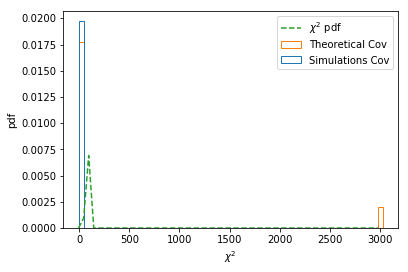

KS between sim. and th. distributions:  Ks_2sampResult(statistic=1.0, pvalue=1.5505547466854487e-45)
KS between sim. and chi2 distributions:  KstestResult(statistic=1.0, pvalue=0.0)
KS between th. and chi2 distributions:  KstestResult(statistic=0.8998257460349258, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.07214355609020984, pvalue=0.6738184342442426)

Difference between analytic and sims. correlation matrix


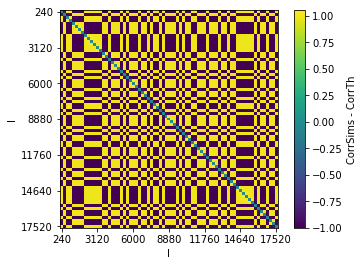

Eigenvalues vs l


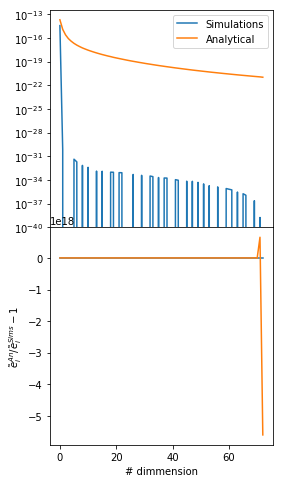

Row of cov. matrix.


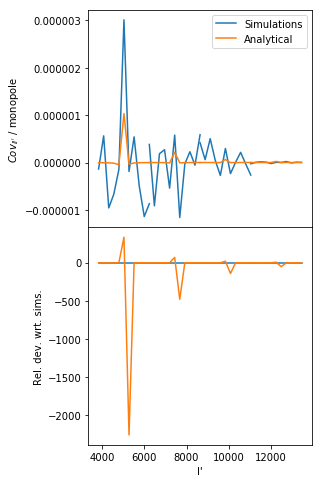

In [56]:
chi2_TTTT, corr_TTTT = co.do_all_checks(lbins[:lmax], clTT[:, :lmax], CovSims_TT[:lmax, :lmax], CovTh_TT[:lmax, :lmax], modes="TTTT")

## TETE

In [ ]:
chi2_TETE, corr_TETE = co.do_all_checks(lbins[:lmax], clTE[:, :lmax], CovSims_TE[:lmax, :lmax], CovTh_TETE[:lmax, :lmax], modes="TETE")

## EEEE

In [ ]:
chi2_EEEE, corr_EEEE = co.do_all_checks(lbins[:lmax], clEE[:, :lmax], CovSims_EE[:lmax, :lmax], CovTh_EEEE[:lmax, :lmax], modes="EEEE")

## BBBB

In [ ]:
chi2_BBBB, corr_BBBB = co.do_all_checks(lbins[:lmax], clBB[:, :lmax], CovSims_BB[:lmax, :lmax], CovTh_BBBB[:lmax, :lmax], modes="BBBB")

## TBTB

In [ ]:
chi2_TBTB, corr_TBTB = co.do_all_checks(lbins[:lmax], clTB[:, :lmax], CovSims_TB[:lmax, :lmax], CovTh_TBTB[:lmax, :lmax], modes="TBTB")

## EBEB

In [ ]:
chi2_EBEB, corr_EBEB = co.do_all_checks(lbins[:lmax], clEB[:, :lmax], CovSims_EB[:lmax, :lmax], CovTh_EBEB[:lmax, :lmax], modes="EBEB")

## TTTE

In [ ]:
chi2_TTTE, corr_TTTE = co.do_all_checks(lbins[:lmax], clTT[:, :lmax], CovSims_TTTE[:lmax, :lmax], CovTh_TTTE[:lmax, :lmax], modes="TTTE", cl2sims=clTE[:, :lmax])

## TTEE

In [ ]:
chi2_TTEE, corr_TTEE = co.do_all_checks(lbins[:lmax], clTT[:, :lmax], CovSims_TTEE[:lmax, :lmax], CovTh_TTEE[:lmax, :lmax], modes="TTEE", cl2sims=clEE[:, :lmax])

## TTBB

In [ ]:
chi2_TTBB, corr_TTBB = co.do_all_checks(lbins[:lmax], clTT[:, :lmax], CovSims_TTBB[:lmax, :lmax], CovTh_TTBB[:lmax, :lmax], modes="TTBB", cl2sims=clBB[:, :lmax])

# Spin0 approximation

## TTTT

In [ ]:
chi20_TTTT, corr0_TTTT = co.do_all_checks(lbins[:lmax], clTT[:, :lmax], CovSims_TT[:lmax, :lmax], CovTh0_TT[:lmax, :lmax], modes="TTTT")

## TETE

In [ ]:
chi20_TETE, corr0_TETE = co.do_all_checks(lbins[:lmax], clTE[:, :lmax], CovSims_TE[:lmax, :lmax], CovTh0_TE[:lmax, :lmax], modes="TETE")

## EEEE

In [ ]:
chi20_EEEE, corr0_EEEE = co.do_all_checks(lbins[:lmax], clEE[:, :lmax], CovSims_EE[:lmax, :lmax], CovTh0_EE[:lmax, :lmax], modes="EEEE")

## BBBB

In [ ]:
chi20_BBBB, corr0_BBBB = co.do_all_checks(lbins[:lmax], clBB[:, :lmax], CovSims_BB[:lmax, :lmax], CovTh0_BB[:lmax, :lmax], modes="BBBB")

## TBTB

In [ ]:
chi20_TBTB, corr0_TBTB = co.do_all_checks(lbins[:lmax], clTB[:, :lmax], CovSims_TB[:lmax, :lmax], CovTh0_TB[:lmax, :lmax], modes="TBTB")

## EBEB

In [ ]:
chi20_EBEB, corr0_EBEB = co.do_all_checks(lbins[:lmax], clEB[:, :lmax], CovSims_EB[:lmax, :lmax], CovTh0_EB[:lmax, :lmax], modes="EBEB")

# Naive approximation

## TTTT

In [ ]:
chi2N_TTTT, corr2N_TTTT = co.do_all_checks(lbins[:lmax], clTT[:, :lmax], CovSims_TT[:lmax, :lmax], CovThN_TT[:lmax, :lmax], modes="TTTT")

In [ ]:
chi2N_TTTT, corr2N_TTTT = co.do_all_checks(lbins[:lmax], clTT[:, :lmax], CovSims_TT[:lmax, :lmax], CovThN_TT[:lmax, :lmax], modes="TTTT")

## TETE

In [ ]:
chi2N_TETE, corrN_TETE = co.do_all_checks(lbins[:lmax], clTE[:, :lmax], CovSims_TE[:lmax, :lmax], CovThN_TE[:lmax, :lmax], modes="TETE")

## EEEE

In [ ]:
chi2N_EEEE, corrN_EEEE = co.do_all_checks(lbins[:lmax], clEE[:, :lmax], CovSims_EE[:lmax, :lmax], CovThN_EE[:lmax, :lmax], modes="EEEE")

## BBBB

In [ ]:
chi2N_BBBB, corrN_BBBB = co.do_all_checks(lbins[:lmax], clBB[:, :lmax], CovSims_BB[:lmax, :lmax], CovThN_BB[:lmax, :lmax], modes="BBBB")

## TBTB

In [ ]:
chi2N_TBTB, corr_TBTB = co.do_all_checks(lbins[:lmax], clTB[:, :lmax], CovSims_TB[:lmax, :lmax], CovThN_TB[:lmax, :lmax], modes="TBTB")

## EBEB

In [ ]:
chi2N_EBEB, corrN_EBEB = co.do_all_checks(lbins[:lmax], clEB[:, :lmax], CovSims_EB[:lmax, :lmax], CovThN_EB[:lmax, :lmax], modes="EBEB")

# Comparing the approximations

## Diagonal & eigenvalues & row cov

In [ ]:
co.do_check_covariance_terms(lbins[:lmax], CovSims_TT[:lmax,:lmax], [CovTh_TT[:lmax,:lmax], CovTh0_TT[:lmax,:lmax], CovThN_TT[:lmax,:lmax]], ['Efstathiou', 'Spin-0 app.', 'Naive app.'], normalization_rows=np.mean(clTT,axis=0)[0]**2, principal=False)

In [ ]:
co.do_check_covariance_terms(lbins[:lmax], CovSims_TE[:lmax,:lmax], [CovTh_TE[:lmax,:lmax], CovTh0_TE[:lmax,:lmax], CovThN_TE[:lmax,:lmax]], ['Efstathiou', 'Spin-0 app.', 'Naive app.'], normalization_rows=np.mean(clTE,axis=0)[0]**2)

In [ ]:
co.do_check_covariance_terms(lbins[:lmax], CovSims_TB[:lmax,:lmax], [CovTh_TB[:lmax,:lmax], CovTh0_TB[:lmax,:lmax], CovThN_TB[:lmax,:lmax]], ['Efstathiou', 'Spin-0 app.', 'Naive app.'], normalization_rows=np.mean(clTB, axis=0)[0]**2 )

In [ ]:
co.do_check_covariance_terms(lbins[:lmax], CovSims_EB[:lmax,:lmax], [CovTh_EB[:lmax,:lmax], CovTh0_EB[:lmax,:lmax], CovThN_EB[:lmax,:lmax]], ['Efstathiou', 'Spin-0 app.', 'Naive app.'], normalization_rows=np.mean(clTB,axis=0)[0]**2)

In [ ]:
co.do_check_covariance_terms(lbins[:lmax], CovSims_EE[:lmax,:lmax], [CovTh_EE[:lmax,:lmax], CovTh0_EE[:lmax,:lmax], CovThN_EE[:lmax,:lmax]], ['Efstathiou', 'Spin-0 app.', 'Naive app.'], normalization_rows=np.mean(clEE,axis=0)[0]**2)

In [ ]:
co.do_check_covariance_terms(lbins[:lmax], CovSims_BB[:lmax,:lmax], [CovTh_BB[:lmax,:lmax], CovTh0_BB[:lmax,:lmax], CovThN_BB[:lmax,:lmax]], ['Efstathiou', 'Spin-0 app.', 'Naive app.'], normalization_rows=np.mean(clBB,axis=0)[0]**2, principal=False)

## $\chi^2$

In [ ]:
co.plot_chi2([chi2_TTTT[0], chi2_TTTT[1], chi20_TTTT[1]], lmax=lmax, labels=['Simulations', 'Efstathiou', 'Spin-0 app.', 'Naive app.'])

In [ ]:
co.plot_chi2([chi2_TETE[0], chi2_TETE[1], chi20_TETE[1]], lmax=lmax, labels=['Simulations', 'Efstathiou', 'Spin-0 app.', 'Naive app.'])

In [ ]:
co.plot_chi2([chi2_TBTB[0], chi2_TBTB[1], chi20_TBTB[1]], lmax=lmax, labels=['Simulations', 'Efstathiou', 'Spin-0 app.', 'Naive app.'])

In [ ]:
co.plot_chi2([chi2_EBEB[0], chi2_EBEB[1], chi20_EBEB[1]], lmax=lmax, labels=['Simulations', 'Efstathiou', 'Spin-0 app.', 'Naive app.'])

In [ ]:
co.plot_chi2([chi2_EEEE[0], chi2_EEEE[1], chi20_EEEE[1]], lmax=lmax, labels=['Simulations', 'Efstathiou', 'Spin-0 app.', 'Naive app.'])

In [ ]:
co.plot_chi2([chi2_BBBB[0], chi2_BBBB[1], chi20_BBBB[1]], lmax=lmax, labels=['Simulations', 'Efstathiou', 'Spin-0 app.', 'Naive app.'])

In [ ]:
co.plot_chi2([chi2_BBBB[0], chi20_BBBB[1]], lmax=lmax, labels=['Simulations', 'Efstathiou', 'Spin-0 app.', 'Naive app.'])

## Covariance rows

In [ ]:
li = 20
for i in range(5):
    X = lbins[:lmax][li-5:li+6]
    #Y = CovSims_TT[li, li-5:li+5]/clTT[0, li-5:li+5]**2
    Y = CovSims_TT[:lmax,:lmax][li, li-5:li+6]/clTT[0, 0]**2
    Yth = CovTh_TT[:lmax,:lmax][li, li-5:li+6]/clTT[0, 0]**2

    li += 2*5

    plt.plot(X, Y, c='blue')
    plt.plot(X, Yth, c='orange')
    
plt.show()
plt.close()

In [ ]:
plt.plot(lbins, CovSims_TT[0])
plt.show()

# Super Cov-TTEEEE

In [ ]:
CovSims_TTTEEE_short =  np.block([[CovSims_TT[:lmax, :lmax], CovSims_TTTE[:lmax, :lmax], CovSims_TTEE[:lmax, :lmax]], 
                        [CovSims_TTTE.T[:lmax, :lmax], CovSims_TE[:lmax, :lmax], CovSims_TEEE[:lmax, :lmax]], 
                        [CovSims_TTEE.T[:lmax, :lmax], CovSims_TEEE.T[:lmax, :lmax], CovSims_EE[:lmax, :lmax]]])
CovTh_TTTEEE_short =  np.block([[CovTh_TT[:lmax, :lmax], CovTh_TTTE[:lmax, :lmax], CovTh_TTEE[:lmax, :lmax]], 
                        [CovTh_TTTE.T[:lmax, :lmax], CovTh_TE[:lmax, :lmax], CovTh_TEEE[:lmax, :lmax]], 
                        [CovTh_TTEE.T[:lmax, :lmax], CovTh_TEEE.T[:lmax, :lmax], CovTh_EE[:lmax, :lmax]]])
clTTTEEE = np.concatenate([clTT[:, :lmax], clTE[:, :lmax], clEE[:, :lmax]], axis=1)
lbinsTTTEEE = np.array([lbins[:lmax]]*3)

In [ ]:
chi2_TTEEEE, corr_TTTEEE = co.do_all_checks(lbinsTTTEEE, clTTTEEE, CovSims_TTTEEE_short, CovTh_TTTEEE_short, modes="TTTTEEE", row_cov=False)